**Author**: Victor Teixidó López

In [2]:
!pip install -q langdetect
!pip install -q datasets
!pip install -q nlpaug
!pip install -q -U accelerate
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
import spacy
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

from datetime import datetime

from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 100

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# REVIEWS OF THEME PARKS

We are going to use 2 different datasets. Overall we will be working with nearly 100,000 reviews.

The [first dataset](https://www.kaggle.com/datasets/arushchillar/disneyland-reviews) collects the opinions and ratings given to 3 Disneyland branches.
- Disneyland California
- Disneyland Hong Kong
- Disneyland Paris

The [second dataset](https://www.kaggle.com/datasets/dwiknrd/reviewuniversalstudio) includes the reviews and ratings given to 3 Universal Studio branches.
- Universal Florida
- Universal Singapore
- Universal Japan

# Disneyland branches

In [4]:
disneyland_data = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/DisneylandReviews.csv', encoding='windows-1252')
disneyland_data.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


The id and location of the reviewer will not provide any useful information. In the same way, knowing when the review was written it doesn't provide any useful information either. For these reasons, we will drop *Review_ID*, *Reviewer_Location*, *Year_Month* columns from the dataset.

In [5]:
disneyland_data.drop(columns=['Review_ID','Reviewer_Location','Year_Month'], inplace=True)
disneyland_data.rename({'Rating': 'ratings', 'Review_Text': 'reviews', 'Branch': 'theme_park'},
                       axis=1, inplace=True)

In [8]:
disneyland_data[['ratings', 'reviews']].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ratings,42656.0,NaN,NaN,NaN,4.217695,1.063371,1.0,4.0,5.0,5.0,5.0
reviews,42656,42632,Disneyland we love it! The service is incomp...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Universal Studio branches

In [9]:
universal_data = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/UniversalStudioReviews.csv', encoding='utf-8')
universal_data.head()

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


The name of the reviewer is irrelevant for our data analysis. We will also obviate the title of each of the ratings. Same as before, the date of the review is not important either. For these reasons, we will drop the variables *reviewer*, *title*, *written_date* columns from the Universal Studio dataset.

In [10]:
universal_data.drop(columns=['reviewer','title','written_date'], inplace=True)
universal_data.rename({'rating': 'ratings', 'review_text': 'reviews', 'branch': 'theme_park'},
                       axis=1, inplace=True)

In [11]:
universal_data[['ratings', 'reviews']].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ratings,50904.0,NaN,NaN,NaN,4.256994,1.046716,1.0,4.0,5.0,5.0,5.0
reviews,50904,50847,This was our second visit this time we a had t...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Combine both datasets

We concatenate both datasets into a single one. Now we have more than 90,000 ratings and reviews from 6 different theme parks.

In [ ]:
df = pd.concat([disneyland_data, universal_data], ignore_index=True)
df.head()

,ratings,reviews,theme_park
0,4.0,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4.0,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4.0,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4.0,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4.0,"the location is not in the city, took around 1...",Disneyland_HongKong


Just to gather some general information, let's see the frecuency of ratings and reviews that we have of each theme park in our combined dataset.

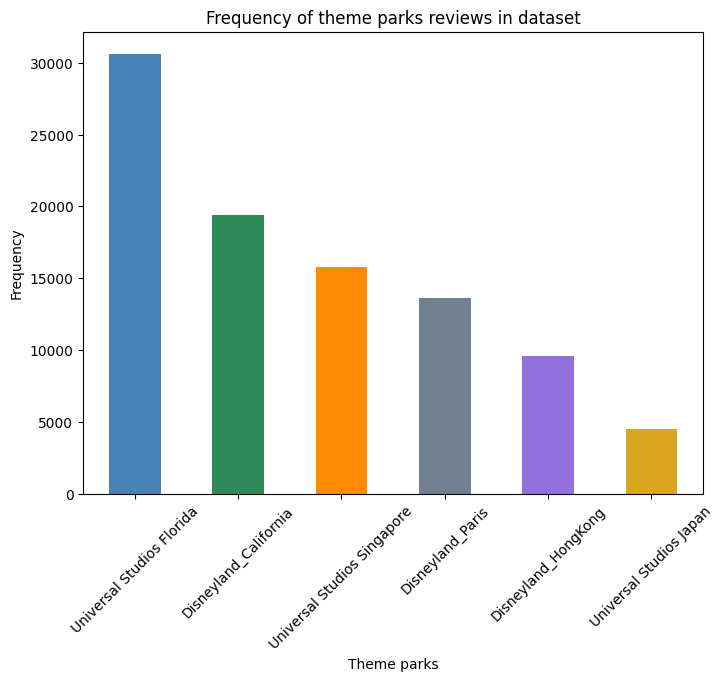

In [ ]:
theme_park_counts = df['theme_park'].value_counts()

plt.figure(figsize=(8, 6))
theme_park_counts.plot(kind='bar', color=['steelblue','seagreen','darkorange','slategray','mediumpurple','goldenrod'])
plt.title("Frequency of theme parks reviews in dataset")
plt.xlabel("Theme parks")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

For some more extra information, let's check how well distributed is our data.

In [ ]:
df['ratings'] = pd.Categorical(df['ratings'], categories=[1,2,3,4,5], ordered=True)
df['ratings'].value_counts()

5    51348
4    24289
3    10338
2     4113
1     3472
Name: ratings, dtype: int64

As we can see in the previous output and in the figure below, we will have to augment the reviews with lower stars to try to balance the data when doing the training.

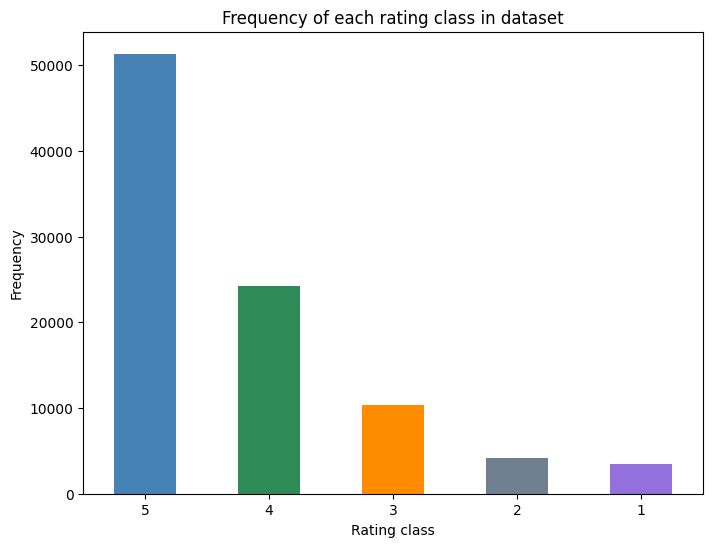

In [ ]:
ratings_counts = df['ratings'].value_counts()

plt.figure(figsize=(8, 6))
ratings_counts.plot(kind='bar', color=['steelblue','seagreen','darkorange','slategray','mediumpurple'])
plt.title("Frequency of each rating class in dataset")
plt.xlabel("Rating class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

We will drop the variable that defines the name of the park from our data. When analyzing and extracting conclusions, this information will not be relevant. We assume data will always come only with the *ratings* and *reviews* columns.

In [ ]:
df.drop(columns=['theme_park'], inplace=True)
df.head()

,ratings,reviews
0,4,If you've ever been to Disneyland anywhere you...
1,4,Its been a while since d last time we visit HK...
2,4,Thanks God it wasn t too hot or too humid wh...
3,4,HK Disneyland is a great compact park. Unfortu...
4,4,"the location is not in the city, took around 1..."


## Save combined dataset

In [ ]:
df.to_csv('/content/drive/MyDrive/UNI/tfg/dataframes/Dataframe.csv', index=False)

## Read combined dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/Dataframe.csv')

# Data splitting

First step will be splitting the data in train, test and validation.

In [ ]:
from sklearn.model_selection import train_test_split

X = df['reviews']
y = df['ratings']

# Divide the data in train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Divide the train data in train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
# Create DataFrames for train, validation, and test sets
train_df = pd.DataFrame({'reviews': X_train, 'ratings': y_train})
train_df.reset_index(drop=True, inplace=True)

val_df = pd.DataFrame({'reviews': X_val, 'ratings': y_val})
val_df.reset_index(drop=True, inplace=True)

test_df = pd.DataFrame({'reviews': X_test, 'ratings': y_test})
test_df.reset_index(drop=True, inplace=True)

# Dataset preprocessing

First step will be checking and guarantee that all reviews are in english or not and remove any text that is not in english.

In [ ]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def delete_not_english_reviews(dataframe):
  X_data = dataframe['reviews']
  y_data = dataframe['ratings']
  cleaned_X_data = []
  cleaned_y_data = []

  for i in range(0, len(X_data)):
    text = X_data[i]
    if isEnglish(text) or detect(text) == 'en':
      cleaned_X_data.append(X_data[i])
      cleaned_y_data.append(y_data[i])

  dataframe = {'reviews': cleaned_X_data, 'ratings': cleaned_y_data}
  dataframe = pd.DataFrame(dataframe)
  return dataframe

Next step consists in normalizing all the reviews with the same format. Converting text to lower case, removing the unicode characters and removing the stopwords.

In [ ]:
def remove_unicode_characters(text):
  text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text)
  return text

stop = stopwords.words('english')
def remove_stopwords(text):
  text = " ".join([word for word in text.split() if word not in (stop)])
  return text

def normalize_text(dataframe):
  X_data = dataframe['reviews']
  X_data = [text.lower() for text in X_data]
  X_data = [remove_unicode_characters(text) for text in X_data]
  X_data = [remove_stopwords(text) for text in X_data]

  dataframe['reviews'] = X_data
  return dataframe

Next step is preprocess the reviews lemattizating all the texts.

In [ ]:
# English model
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
  doc = nlp(text)
  return ' '.join([token.lemma_ for token in doc])

Final process consists in augmenting the data for the reviews with lower ratings. This will help future models to perform betters in those classes.

In [ ]:
from itertools import chain

def insert_reviews_into_df(dataframe, rating, reviews):
  data = {'ratings': [rating] * len(reviews),
          'reviews': reviews}

  return dataframe.append(pd.DataFrame(data), ignore_index=True)

def augment_lower_categories(dataframe):
  aug = naw.SynonymAug(aug_src='wordnet')
  n = 1 # Data will be doubled

  # Add negative synthetic reviews to dataframe
  negative_reviews = dataframe[dataframe['ratings'] == 0]['reviews']
  negative_reviews_augmented = [aug.augment(review, n=n) for review in negative_reviews]
  negative_reviews_augmented = list(chain(*negative_reviews_augmented))
  dataframe = insert_reviews_into_df(dataframe, 0, negative_reviews_augmented)

  # Add neutral synthetic reviews to dataframe
  neutral_reviews = dataframe[dataframe['ratings'] == 1]['reviews']
  neutral_reviews_augmented = [aug.augment(review, n=n) for review in neutral_reviews]
  neutral_reviews_augmented = list(chain(*neutral_reviews_augmented))
  dataframe = insert_reviews_into_df(dataframe, 1, neutral_reviews_augmented)

  return dataframe

Let's apply all the mentioned changes into our data.

In [ ]:
def preprocess_data(dataframe, bAugmentData):

  # Preprocess reviews
  dataframe = delete_not_english_reviews(dataframe)                               # Delete not in english reviews
  dataframe = normalize_text(dataframe)                                           # Normalize data
  dataframe['reviews'] = [lemmatize_text(text) for text in dataframe['reviews']]  # Lemmatize text

  # Preprocess ratings
  y_data = dataframe['ratings']
  y_data = pd.Categorical(y_data, categories=[1,2,3,4,5], ordered=True)
  y_data = [2 if rating >= 4 else 1 if rating == 3 else 0 for rating in y_data]
  dataframe['ratings'] = y_data

  # Data augmentation (except for test data)
  if (bAugmentData):
    dataframe = augment_lower_categories(dataframe)

  return dataframe

## Preprocess and save train data

In [ ]:
train_df = preprocess_data(train_df, True)
train_df.to_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTrainData.csv', index=False)

## Preprocess and save validation data

In [ ]:
val_df = preprocess_data(val_df, True)
val_df.to_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedValidationData.csv', index=False)

## Preprocess and save test data

In [ ]:
test_df = preprocess_data(test_df, False)
test_df.to_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTestData.csv', index=False)